In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import trafficFeaturing as tf

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

# Always make it pretty.
plt.style.use('ggplot')

In [2]:
traffic = tf.clean_data(tf.load_data())
traffic.shape

(275383, 21)

In [3]:
traffic = tf.add_previous(traffic,traffic.columns[3:])

In [4]:
#reorders columns so slicing out features, non-features, and targets is easier later on
cols = traffic.columns.tolist()
cols = cols[:5] + cols[6:] + [cols[5]]
traffic = traffic[cols]
# traffic.columns

In [5]:
y = traffic[['AADFYear','CP','Estimation_method', 'Estimation_method_detailed','AllMotorVehicles']]
categorical_columns = ['RoadCategory', 'previous_Estimation_method_detailed', 'previous_RoadCategory','AADFYear'] 
traffic = pd.get_dummies(traffic,columns=categorical_columns)

traffic['AADFYear'] = y['AADFYear']
cols = traffic.columns.tolist()
cols = cols[-1:] + cols[:-1]
traffic = traffic[cols]

traffic_estimated = traffic[traffic['Estimation_method'] == 'Estimated']
traffic_counted = traffic[traffic['Estimation_method'] == 'Counted']
traffic_after2000 = traffic[traffic['AADFYear_2000'] == False]

y_estimated = y[traffic['Estimation_method'] == 'Estimated']
y_counted = y[traffic['Estimation_method'] == 'Counted']
y_after2000 = y[traffic['AADFYear_2000'] == False]

In [6]:
main_train = []
main_test = []
estimated_train = []
estimated_test = []
counted_train = []
counted_test = []

for year in np.arange(2000,2017,1):
    trainer, tester = tf.train_test_splitter(traffic,year)
    trainer2, tester2 = tf.train_test_splitter(traffic_estimated,year)
    trainer3, tester3 = tf.train_test_splitter(traffic_counted,year)
    main_train.append(trainer.values)
    main_test.append(tester.values)
    estimated_train.append(trainer2.values)
    estimated_test.append(tester2.values)
    counted_train.append(trainer3.values)
    counted_test.append(tester3.values)
#train test splitting for final model

main_split = zip(main_train, main_test)
estimated_split = zip(estimated_train, estimated_test)
counted_split = zip(counted_train, counted_test)

In [7]:
X = traffic.values[:,17:]
X_estimated = traffic_estimated.values[:,17:]
X_counted = traffic_counted.values[:,17:]
X_after2000 = traffic_after2000.values[:,17:]

y_estimated_flow = y_estimated.values[:,4]
y_counted_flow = y_counted.values[:,4]

In [8]:
forest2 = RandomForestRegressor()

In [10]:
kf = KFold(n_splits = 5,shuffle=True)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9773394702112286
0.9775550843055021
0.9758472989597895
0.9774008114557277
0.9794690027346898


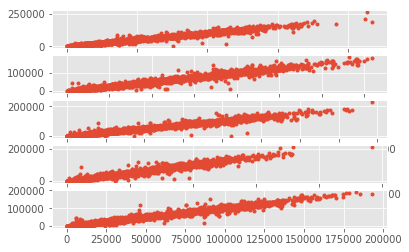

In [11]:
fig, axs = plt.subplots(5)

for i, (train, test) in enumerate(kf.split(X_counted)):
    forest2.fit(X_counted[train],y_counted_flow[train])
    print(forest2.score(X_counted[test],y_counted_flow[test]))
    axs[i].plot(forest2.predict(X_counted[test]),y_counted_flow[test],".")

0.9968736759656809
0.9970804601426951
0.9965129282646489
0.994321653091396
0.9946366904042188


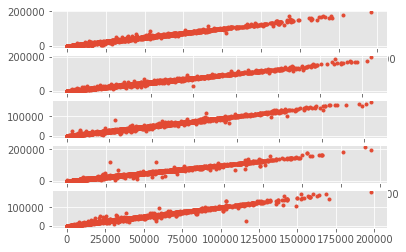

In [15]:
fig, axs = plt.subplots(5)

for i, (train, test) in enumerate(kf.split(X_estimated)):
    forest2.fit(X_estimated[train],y_estimated_flow[train])
    print(forest2.score(X_estimated[test],y_estimated_flow[test]))
    axs[i].plot(forest2.predict(X_estimated[test]),y_estimated_flow[test],".")

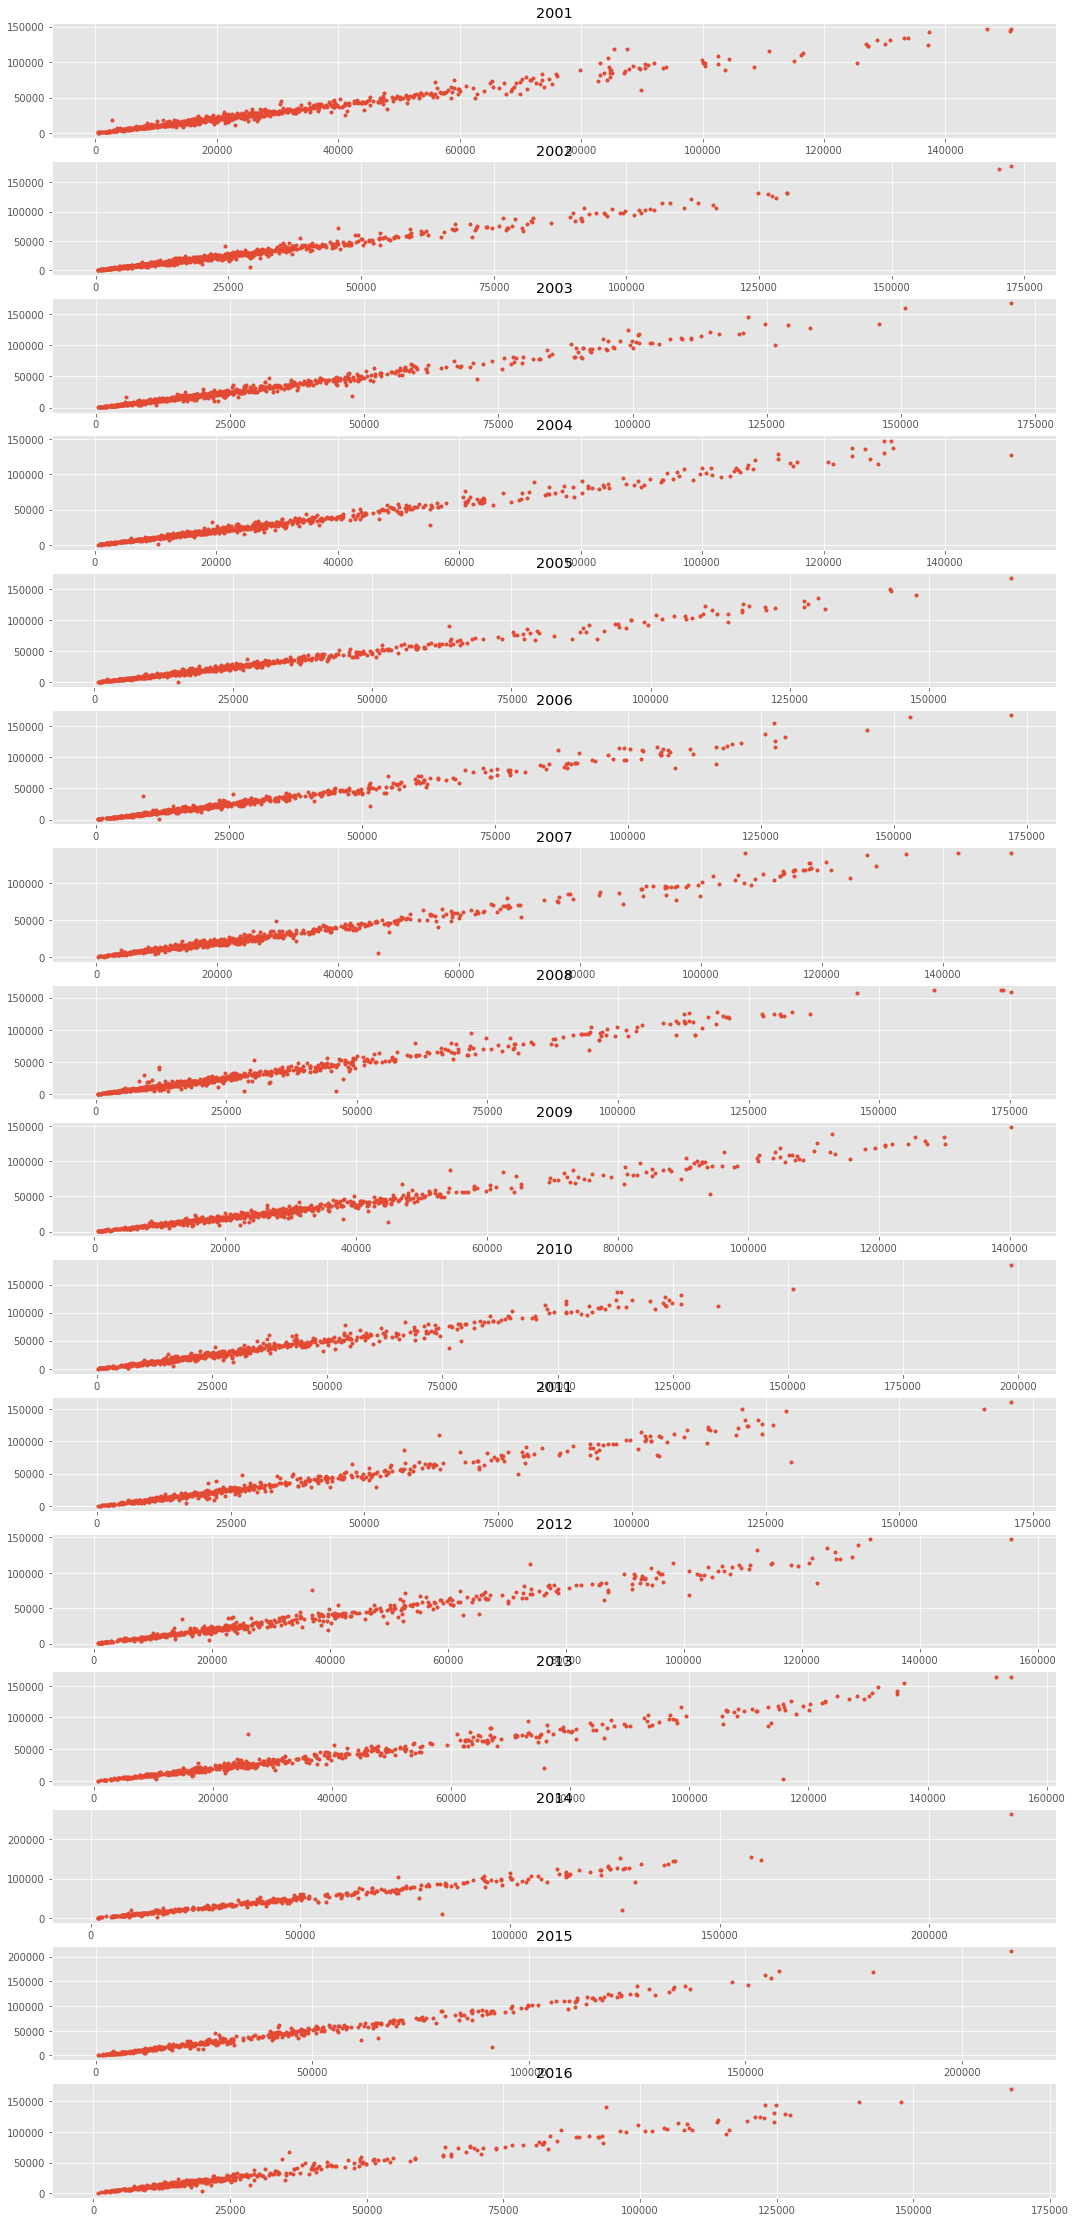

In [16]:
fig, axs = plt.subplots(16, figsize = (18,40))

num_years = len(counted_train)-1
my_model_scores = np.zeros(num_years)

for d in range(num_years):
    i = d+1
    forest2.fit(X_counted[counted_train[i].astype(bool)],y_counted_flow[counted_train[i].astype(bool)])
    my_model_scores[d] = forest2.score(X_counted[counted_test[i].astype(bool)],y_counted_flow[counted_test[i].astype(bool)])
    axs[d].plot(forest2.predict(X_counted[counted_test[i].astype(bool)]),y_counted_flow[counted_test[i].astype(bool)],".")
    axs[d].set_title(str(2001+d))

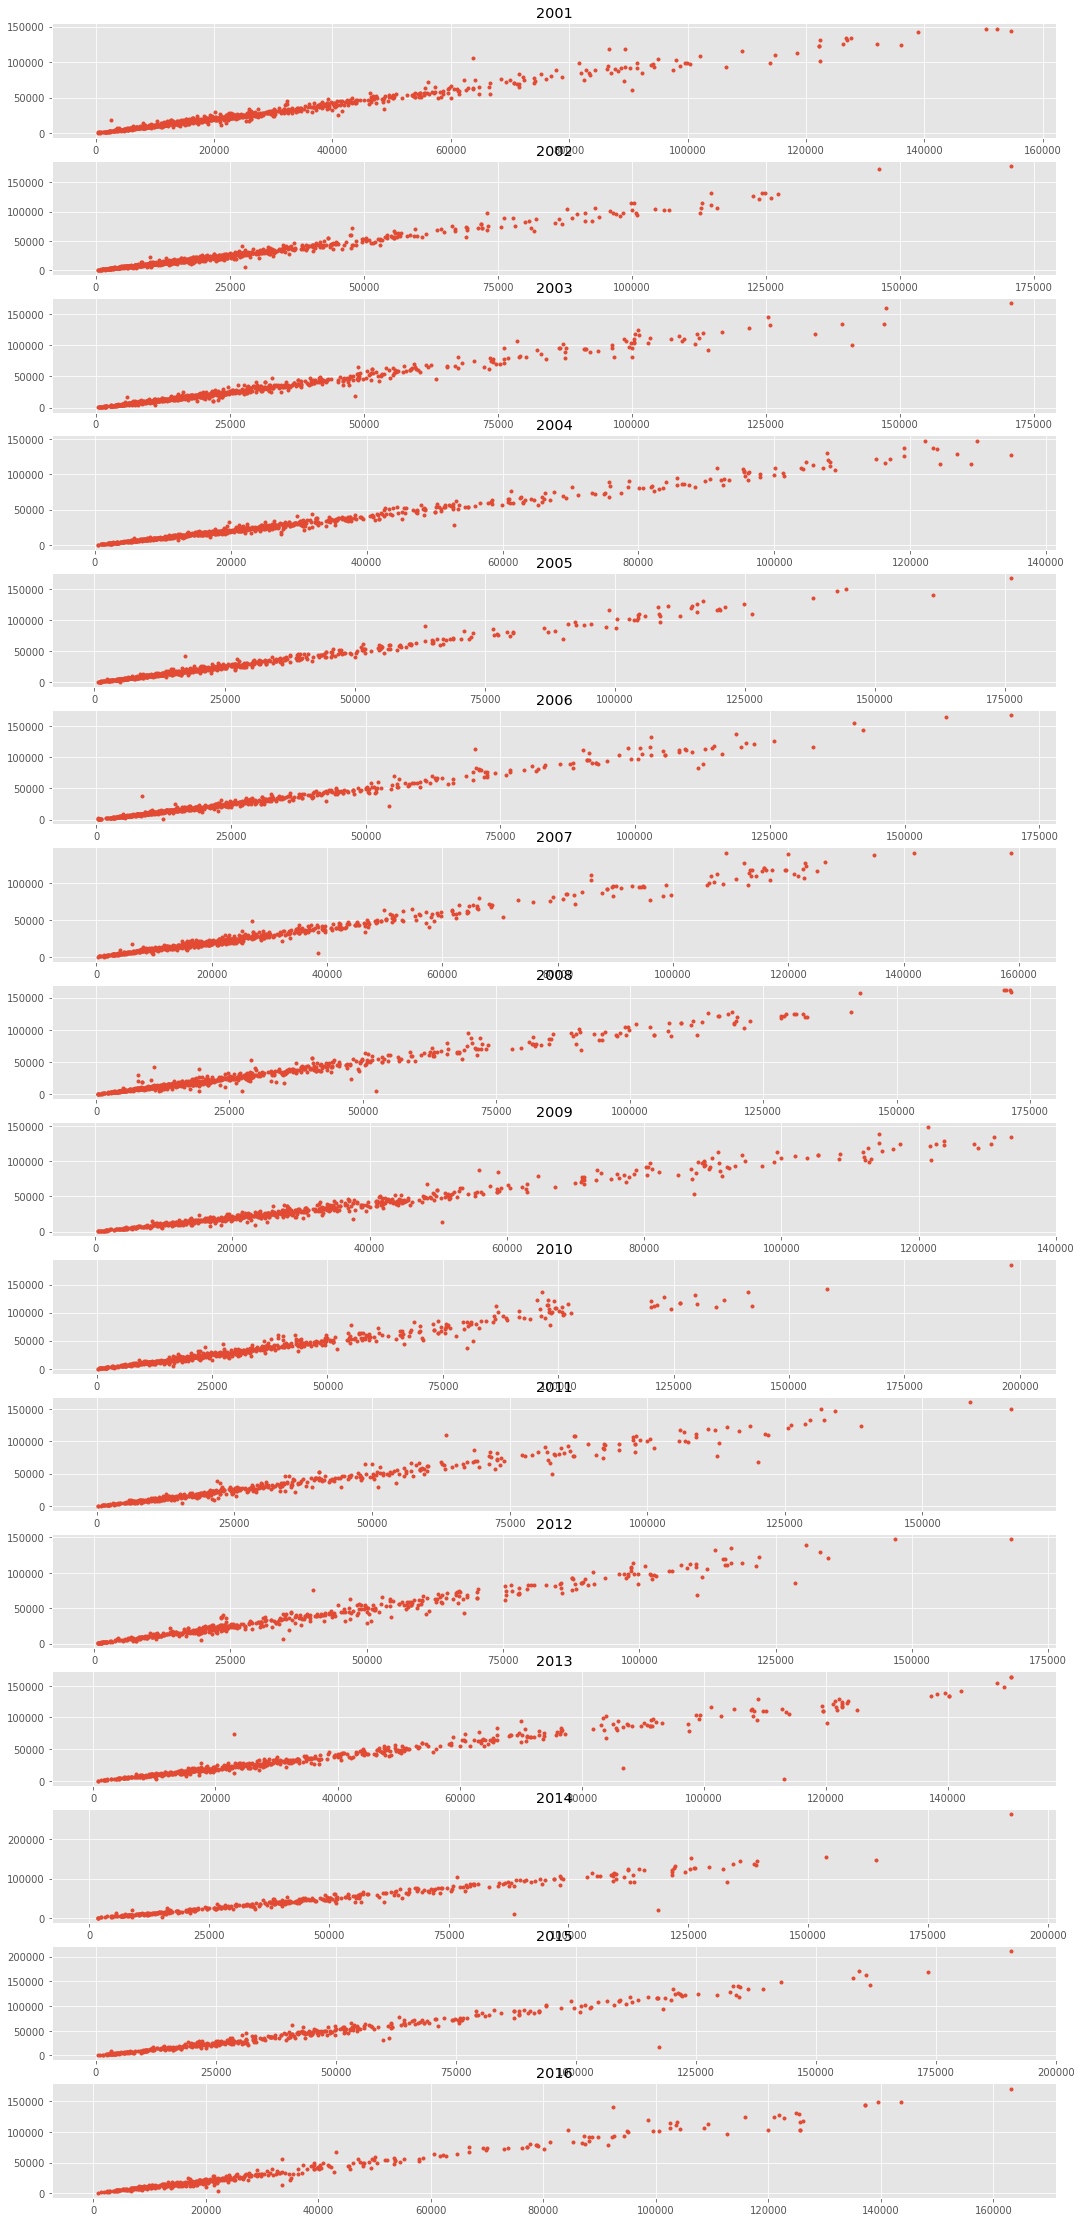

In [17]:
fig, axs = plt.subplots(16, figsize = (18,40))

model_of_model_scores = np.zeros(num_years)

for d in range(num_years):
    i = d + 1
    forest2.fit(X_estimated,y_estimated_flow)
    model_of_model_scores[d] = forest2.score(X_counted[counted_test[i].astype(bool)],y_counted_flow[counted_test[i].astype(bool)])
    axs[d].plot(forest2.predict(X_counted[counted_test[i].astype(bool)]),y_counted_flow[counted_test[i].astype(bool)],".")
    axs[d].set_title(str(2001+d))

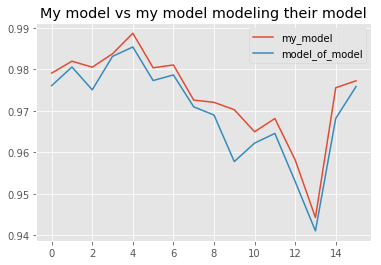

In [14]:
x= range(num_years)

plt.axis(ylim=(0,1))
plt.plot(x, my_model_scores)
plt.plot(x, model_of_model_scores)
plt.legend(['my_model','model_of_model'])
plt.title('My model vs my model modeling their model')
None